This data was extracted from the census bureau database found at

http://www.census.gov/ftp/pub/DES/www/welcome.html

Donor: Ronny Kohavi and Barry Becker,
Data Mining and Visualization
Silicon Graphics.

e-mail: ronnyk@sgi.com for questions.
Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
48842 instances, mix of continuous and discrete (train=32561, test=16281)
45222 if instances with unknown values are removed (train=30162, test=15060)
Duplicate or conflicting instances : 6
Class probabilities for adult.all file
Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)
Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

Extraction was done by Barry Becker from the 1994 Census database. A set of
reasonably clean records was extracted using the following conditions:
((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) Prediction task is to
determine whether a person makes over 50K a year. Conversion of original data as
follows:

1. Discretized a gross income into two ranges with threshold 50,000.
2. Convert U.S. to US to avoid periods.
3. Convert Unknown to "?"
4. Run MLC++ GenCVFiles to generate data,test.

Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the civilian
noninstitutional population of the US. These are prepared monthly for us by Population
Division here at the Census Bureau. We use 3 sets of controls.

These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through them 6
times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating "weighted
tallies" of any specified socio-economic characteristics of the population. People with
similar demographic characteristics should have similar weights. There is one important
caveat to remember about this statement. That is that since the CPS sample is actually a
collection of 51 state samples, each with its own probability of selection, the statement
only applies within state.

Problem 1:
Prediction task is to determine whether a person makes over 50K a year.

Problem 2:
Which factors are important

Problem 3:
Which algorithms are best for this dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
 'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
'Hours/Week','Native country','Income']

In [3]:
train = pd.read_csv('adult-training.csv', names=columns)
test = pd.read_csv('adult-test.csv', names=columns, skiprows=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         32561 non-null object
fnlgwt            32561 non-null int64
Education         32561 non-null object
Education num     32561 non-null int64
Marital Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital Gain      32561 non-null int64
Capital Loss      32561 non-null int64
Hours/Week        32561 non-null int64
Native country    32561 non-null object
Income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df = pd.concat([train, test], axis=0)
dff=df
k=df

In [5]:
df['Income'] = df['Income'].apply(lambda x: 1 if x==' >50K' else 0)

In [6]:
for col in df.columns:
    if type(df[col][0]) == str:
        print("Working on " + col)
        df[col] = df[col].apply(lambda val: val.replace(" ",""))

In [7]:
df.replace(' ?', np.nan, inplace=True)###making copy for visualization

In [8]:
df = pd.concat([df, pd.get_dummies(df['Workclass'],prefix='Workclass',prefix_sep=':')], axis=1)
df.drop('Workclass',axis=1,inplace=True)



df = pd.concat([df, pd.get_dummies(df['Marital Status'],prefix='Marital Status',prefix_sep=':')], axis=1)
df.drop('Marital Status',axis=1,inplace=True)



df = pd.concat([df, pd.get_dummies(df['Occupation'],prefix='Occupation',prefix_sep=':')], axis=1)
df.drop('Occupation',axis=1,inplace=True)



df = pd.concat([df, pd.get_dummies(df['Relationship'],prefix='Relationship',prefix_sep=':')], axis=1)
df.drop('Relationship',axis=1,inplace=True)



df = pd.concat([df, pd.get_dummies(df['Race'],prefix='Race',prefix_sep=':')], axis=1)
df.drop('Race',axis=1,inplace=True)



df = pd.concat([df, pd.get_dummies(df['Sex'],prefix='Sex',prefix_sep=':')], axis=1)
df.drop('Sex',axis=1,inplace=True)



df = pd.concat([df, pd.get_dummies(df['Native country'],prefix='Native country',prefix_sep=':')], axis=1)
df.drop('Native country',axis=1,inplace=True)



df.drop('Education', axis=1,inplace=True)
df.head()

,Age,fnlgwt,Education num,Capital Gain,Capital Loss,Hours/Week,Income,Workclass: Federal-gov,Workclass: Local-gov,Workclass: Never-worked,...,Native country: Portugal,Native country: Puerto-Rico,Native country: Scotland,Native country: South,Native country: Taiwan,Native country: Thailand,Native country: Trinadad&Tobago,Native country: United-States,Native country: Vietnam,Native country: Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


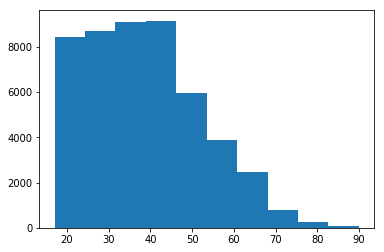

In [9]:
plt.hist(dff['Age']);
dff['Income'] = dff['Income'].apply(lambda x: 1 if x==' >50K.' else 0)
dff.replace(' ?', np.nan, inplace=True)

# Preparing data for Training and testing 

In [24]:
X = np.array(df.drop(['Income'], 1))
y = np.array(df['Income'])
X = preprocessing.scale(X)
y = np.array(df['Income'])



C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [27]:
#Splitting data as train and test data 

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

# Applying LOGISTIC REGRESSION model

In [28]:
from sklearn.metrics import accuracy_score

lrn = LogisticRegression(penalty = 'l1', C = .001, class_weight='balanced')



lrn.fit(X_train, y_train)

y_pred = lrn.predict(X_test)

In [29]:
print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

LRA = accuracy_score(y_test, y_pred)

print("The Accuracy for Logistic Regression is {}".format(LRA))

[[5432 2731]
 [ 206 1400]]
             precision    recall  f1-score   support

          0       0.96      0.67      0.79      8163
          1       0.34      0.87      0.49      1606

avg / total       0.86      0.70      0.74      9769

The Accuracy for Logistic Regression is 0.6993551028764459


# Applying LINEAR REGRESSION model

In [30]:
from sklearn import linear_model

from sklearn.metrics import accuracy_score



lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)

y_lmpre = lm.predict(X_test)



ylm = np.around(y_lmpre)



lm.score(X_train, y_train)

lm.coef_

lm.intercept_

0.15935161588892055

In [31]:
print(confusion_matrix(y_test,ylm))

print(classification_report(y_test,ylm))



LA = accuracy_score(y_test, ylm)

print("The Accuracy for Linear Regression is {}".format(LA))

[[8088   75]
 [1447  159]]
             precision    recall  f1-score   support

          0       0.85      0.99      0.91      8163
          1       0.68      0.10      0.17      1606

avg / total       0.82      0.84      0.79      9769

The Accuracy for Linear Regression is 0.8442010441191524


# Applying KNN model

In [32]:
from sklearn import preprocessing, cross_validation, neighbors

from sklearn.metrics import accuracy_score



clf = neighbors.KNeighborsClassifier()



clf.fit(X_train, y_train)



knnpre = clf.predict(X_test)



In [33]:
print(confusion_matrix(y_test,knnpre))

print(classification_report(y_test,knnpre))

KKNA = accuracy_score(y_test, knnpre)

print("The Accuracy for KNN is {}".format(KKNA))

[[7618  545]
 [1102  504]]
             precision    recall  f1-score   support

          0       0.87      0.93      0.90      8163
          1       0.48      0.31      0.38      1606

avg / total       0.81      0.83      0.82      9769

The Accuracy for KNN is 0.8314054662708568


# Applying Decision tree model

In [34]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export

from sklearn import metrics



clf_tree = DecisionTreeClassifier( max_depth = 4 )



clf_tree.fit( X_train, y_train )

tree_predict = clf_tree.predict( X_test )

metrics.accuracy_score( y_test, tree_predict )



print(confusion_matrix(y_test,tree_predict))

print(classification_report(y_test,tree_predict))

DTA = accuracy_score(y_test, tree_predict)

print("The Accuracy for Decision Tree Model is {}".format(DTA))

[[8006  157]
 [1243  363]]
             precision    recall  f1-score   support

          0       0.87      0.98      0.92      8163
          1       0.70      0.23      0.34      1606

avg / total       0.84      0.86      0.82      9769

The Accuracy for Decision Tree Model is 0.8566895280990889


# Applying  NAIVE BAYES model

In [35]:
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics

from sklearn.metrics import accuracy_score



model = GaussianNB()



# Train the model using the training sets 

model.fit(X_train, y_train)



#Predict Output 

naive_pre= model.predict(X_test)

print (naive_pre)

##result

print(confusion_matrix(y_test,naive_pre))

print(classification_report(y_test,naive_pre))

NBA = accuracy_score(y_test, naive_pre)

print("The Accuracy for NB is {}".format(NBA))

#The output for this line of code can be found at : https://tinyurl.com/yatb56wa

 

[1 1 0 ... 1 1 1]
[[2298 5865]
 [  58 1548]]
             precision    recall  f1-score   support

          0       0.98      0.28      0.44      8163
          1       0.21      0.96      0.34      1606

avg / total       0.85      0.39      0.42      9769

The Accuracy for NB is 0.39369433923635994


# Applying KMeans Model

In [36]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=2)

k_means.fit(X_train) 

labels = k_means.labels_

centroids  = k_means.cluster_centers_.squeeze()

labelspre = k_means.predict(X_test)

print(confusion_matrix(y_test,labelspre))

print(classification_report(y_test,labelspre))

KmeanA = accuracy_score(y_test, labelspre)

print("The Accuracy for kmeans is {}".format(KmeanA))

 

[[5398 2765]
 [ 377 1229]]
             precision    recall  f1-score   support

          0       0.93      0.66      0.77      8163
          1       0.31      0.77      0.44      1606

avg / total       0.83      0.68      0.72      9769

The Accuracy for kmeans is 0.678370355205241


# XGB experiementing with learning rate

Best: -0.292374 using {'learning_rate': 0.3}
-0.687351 (0.000038) with: {'learning_rate': 0.0001}
-0.639926 (0.000332) with: {'learning_rate': 0.001}
-0.412346 (0.001942) with: {'learning_rate': 0.01}
-0.297851 (0.003814) with: {'learning_rate': 0.1}
-0.294995 (0.003994) with: {'learning_rate': 0.2}
-0.292374 (0.004055) with: {'learning_rate': 0.3}


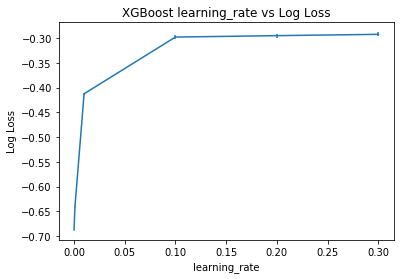

In [37]:
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV



model = xgb.XGBClassifier()

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = dict(learning_rate=learning_rate)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)

grid_result = grid_search.fit(X_train, y_train)



# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):

	print("%f (%f) with: %r" % (mean, stdev, param))





from matplotlib import pyplot

# plot

pyplot.errorbar(learning_rate, means, yerr=stds)

pyplot.title("XGBoost learning_rate vs Log Loss")

pyplot.xlabel('learning_rate')

pyplot.ylabel('Log Loss')

pyplot.savefig('learning_rate.png')

# This xgboost code is where I experiment which learning rate and what number of estimators are BEST

In [ ]:
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import LabelEncoder

import matplotlib

import numpy

from matplotlib import pyplot

from pandas import read_csv

# grid search

model = XGBClassifier()

n_estimators = [100, 200, 300, 400, 500]

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)

grid_result = grid_search.fit(X_train, y_train)

# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):

	print("%f (%f) with: %r" % (mean, stdev, param))

# plot results

scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))

for i, value in enumerate(learning_rate):

    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))

pyplot.legend()

pyplot.xlabel('n_estimators')

pyplot.ylabel('Log Loss')

pyplot.savefig('n_estimators_vs_learning_rate.png')

# XGboost - Picking the best values for learning rate and estimators  

In [ ]:
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(learning_rate=0.1,

                           n_estimators=500,

                           max_depth=5,

                           min_child_weight=4

                           )

final_m=model.fit(X_train, y_train)

xgb.plot_importance(final_m)

plt.show()

predictions = model.predict(X_test)

print("training set auc:",accuracy_score(y_test, predictions))

predictions = model.predict(X_test)

print("test set auc:",accuracy_score(y_test, predictions))

print(model.get_params())



XGBA = accuracy_score(y_test, predictions)

print("The Accuracy  is {}".format(XGBA))

As you can see the max accuracy is achieved with XgBoost. 
